In [2]:
# Standard Imports
import numpy as np
from time import time
import pandas as pd
from matplotlib import pyplot as plt

# SHAPER
from src.Observables import Observable
from src.Shaper import Shaper
from src.Manifolds import Coordinates2D, Simplex, PositiveReals

# Utils
from utils.data_utils import load_cmsopendata, load_dataset, calculate_masses, normalize_events, add_pileup
from utils.plot_utils import plot_event
from ot.lp import emd2

# Jets
from pyjet import cluster



# GPU nonsense
import torch 
import torch.nn as nn

if torch.cuda.is_available():  
    dev = "cuda:0" 
    print("Using GPU!")
else:  
    dev = "cpu"  
    print("Using CPU!")
device = torch.device(dev) 


/home/rikab/miniconda3/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Using CPU!


# Data

(300, 200, 3)
(300, 200, 3)
652.7005


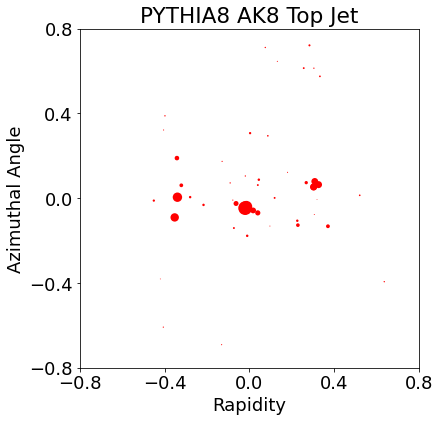

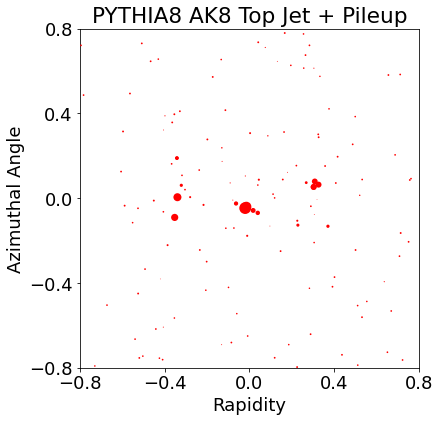

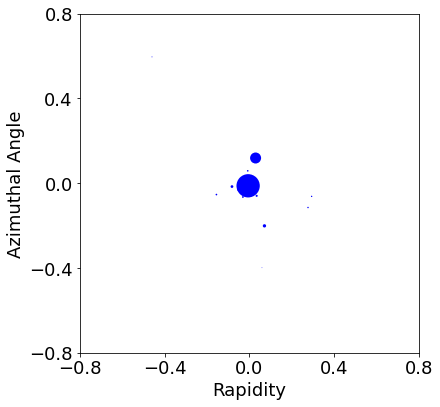

163.98135626462013 5.293781232504222
328.4854342491435 34.911421374316824


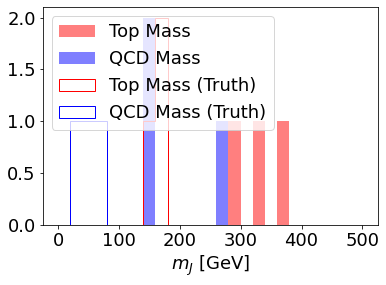

(array([1., 0., 0., 0., 0., 0., 0., 1., 0., 1.]),
 array([121.27475797, 128.79410612, 136.31345428, 143.83280243,
        151.35215058, 158.87149873, 166.39084689, 173.91019504,
        181.42954319, 188.94889134, 196.4682395 ]),
 <BarContainer object of 10 artists>)

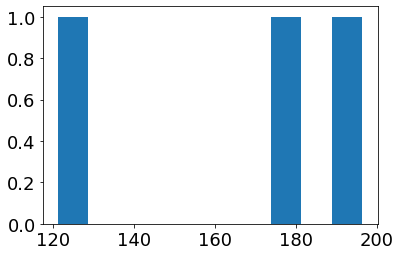

In [3]:
# Parameters
R = 0.8
beta = 1
N = 3
batch_size = 500

mass_lower = 0
mass_upper = np.inf
pt_lower = 475
pt_upper = 525
eta = 1.9
quality = 2
pad = 125
plot_dir = "results"


# Load events
signal = load_dataset("../Datasets/top/v0/signal_train.npy", N, mass_lower, mass_upper, eta, normalize = False)
background = load_dataset("../Datasets/top/v0/background_train.npy", N, mass_lower, mass_upper, eta, normalize = False)
signal_mass = calculate_masses(signal)
background_mass = calculate_masses(background)


# Add pileup
signal_pu, signal_norms = normalize_events(add_pileup(signal, 100, 50, 250, 25, R), return_norm= True)
background_pu, background_norms = normalize_events(add_pileup(background, 100, 50, 250, 25, R), return_norm= True)
signal_pu_mass = signal_norms * calculate_masses(signal_pu)
background_pu_mass = background_norms * calculate_masses(background_pu)



events = [signal, background]
event_labels = ["signal", "background"]
colors = ["red", "blue"]




# Example plots
example_signal = signal[0]
example_signal_pu = signal_pu[0]
print(example_signal[1].sum())
plot_event(example_signal[0], example_signal[1], R, color = "red", title = "PYTHIA8 AK8 Top Jet", filename= "Plots/top.pdf")
plot_event(example_signal_pu[0], example_signal_pu[1], R, color = "red", title = "PYTHIA8 AK8 Top Jet + Pileup", filename = "Plots/top_pileup.pdf")

example_background = background[0]
plot_event(example_background[0], example_background[1], R, color = "blue")

print(np.mean(signal_mass), np.std(signal_mass))
print(np.mean(signal_pu_mass), np.std(signal_pu_mass))


plt.hist(signal_pu_mass, color = "red", bins = 25, range = [0, 500], label = "Top Mass", alpha = 0.5, histtype="stepfilled")
plt.hist(background_pu_mass, color = "blue", bins = 25, range = [0, 500], label = "QCD Mass", alpha = 0.5, histtype="stepfilled")
plt.hist(signal_mass, color = "red", bins = 25, range = [0, 500], label = "Top Mass (Truth)", alpha = 1.0, histtype="step")
plt.hist(background_mass, color = "blue", bins = 25, range = [0, 500], label = "QCD Mass (Truth)", alpha = 1.0, histtype="step")
plt.legend(loc = "upper left")
plt.xlabel(r"$m_J$ [GeV]")
plt.show()


plt.hist(signal_pu_mass - signal_mass)



In [4]:
from matplotlib.patches import Circle as pltCircle
from matplotlib.collections import PathCollection


# Sample at N weighted Dirac deltas
def point_sampler(N, param_dict):
    return (param_dict["Points"].params, param_dict["Weights"].params)

def point_plotter(ax, param_dict):

    centers = param_dict["Points"].params.clone().detach().numpy()
    weights = param_dict["Weights"].params.clone().detach().numpy()
    num = param_dict["Points"].N

    for i in range(num):

        # Center
        ax.scatter(centers[i,0], centers[i,1], color = "Purple", label = "Disk", marker = "x", s = 2 * weights[i] * 500/np.sum(weights), alpha = 0.5)
        
        # Text
        plt.text(0.05, 0.06 + 0.03*i, "Point: (%.3f, %.3f), Weight: %.3f" % (centers[i,0], centers[i,1], weights[i]), fontsize = 10, transform = plt.gca().transAxes)



# Disk
def disk_sampler(N, param_dict):

    centers = param_dict["Points"].params
    num = param_dict["Points"].N
    radii = param_dict["Radius"].params
    weights = param_dict["Structure Weights"].params

    phi = 2 * np.pi * torch.rand(num, N)
    r =  torch.sqrt(torch.rand(num, N))
    points = torch.stack([torch.cos(phi), torch.sin(phi)], axis = 1) * radii[:,None, None]  * r[:,None,:] + centers[:,:,None]


    # Concatenate and reweight
    e = points.reshape((-1, 2))
    z = torch.cat([weights[i] * torch.ones((N,)) / N for i in range(num)], dim = 0)
    return (e, z)


def disk_plotter(ax, param_dict):

    centers = param_dict["Points"].params.clone().detach().numpy()
    radii = param_dict["Radius"].params.clone().detach().numpy()
    weights = param_dict["Structure Weights"].params.clone().detach().numpy()
    num = param_dict["Points"].N

    for i in range(num):
        # Circle
        draw_circle = pltCircle(centers[i,:], radii[i], facecolor = "purple", edgecolor = "purple", alpha = 0.25)
        ax.add_artist(draw_circle)
  
        # Text
        plt.text(0.05, 0.06 + 0.03*i, "Point: (%.3f, %.3f), Weight: %.3f, Radius: %.3f" % (centers[i,0], centers[i,1], weights[i], radii[i]), fontsize = 10, transform = plt.gca().transAxes)


# Point plus disk
def point_disk_sampler(N, param_dict):

    centers = param_dict["Points"].params
    num = param_dict["Points"].N
    radii = param_dict["Radius"].params
    weights = param_dict["Structure Weights"].params

    phi = 2 * np.pi * torch.rand(num, N)
    r =  torch.sqrt(torch.rand(num, N))
    points = torch.stack([torch.cos(phi), torch.sin(phi)], axis = 1) * radii[:,None, None]  * r[:,None,:] + centers[:,:,None]


    # Concatenate and reweight
    e = torch.cat([centers, points.reshape((-1, 2))], dim = 0)
    z1 = torch.cat([weights[i] * torch.ones((1,)) for i in range(num)], dim = 0)
    z2 = torch.cat([weights[num + i] * torch.ones((N,)) / N for i in range(num)], dim = 0)
    z = torch.cat([z1, z2], dim = 0)
    return (e, z)


def point_disk_plotter(ax, param_dict):

    centers = param_dict["Points"].params.clone().detach().numpy()
    radii = param_dict["Radius"].params.clone().detach().numpy()
    weights = param_dict["Structure Weights"].params.clone().detach().numpy()
    num = param_dict["Points"].N

    for i in range(num):
        # Circle
        draw_circle = pltCircle(centers[i,:], radii[i], facecolor = "purple", edgecolor = "purple", alpha = 0.25)
        ax.add_artist(draw_circle)

        # Center
        ax.scatter(centers[i,0], centers[i,1], color = "Purple", label = "Disk", marker = "x", s = 2 * weights[i] * 500/np.sum(weights), alpha = 0.5)
        
        # Text
        plt.text(0.05, 0.06 + 0.03*i, "Point: (%.3f, %.3f), Weight: %.3f, Radius: %.3f" % (centers[i,0], centers[i,1], weights[0], radii[i]), fontsize = 10, transform = plt.gca().transAxes)


# Sample from a normalized uniform distribution
def uniform_sampler(N, param_dict):
    points = torch.FloatTensor(N, 2).uniform_(-R, R)
    zs = torch.ones((N,)) / N
    return (points, zs)



n = 3
_3subjettiness = Observable({"Points" : Coordinates2D(n), "Weights" : Simplex(n)}, point_sampler, beta = 1, R = R, initializer= "kt", plotter = point_plotter)
_3diskiness = Observable({"Points" : Coordinates2D(n), "Structure Weights" : Simplex(n), "Radius" : PositiveReals(n, R/2)}, disk_sampler, beta = 1, R = R, initializer= "kt", plotter = disk_plotter)
_3point_diskiness = Observable({"Points" : Coordinates2D(n), "Structure Weights" : Simplex(2*n), "Radius" : PositiveReals(n, R/2)}, point_disk_sampler, beta = 1, R = R, initializer= "kt", plotter = point_disk_plotter)

_isotropy = Observable({}, uniform_sampler, beta = 1, R = 0.8)
_3subjettiness_plus_pileup = (_isotropy + _3subjettiness)
_3diskiness_plus_pileup = (_isotropy + _3diskiness)
_3point_diskiness_plus_pileup = (_isotropy + _3point_diskiness)

plot_dictionary = {
    "plot_directory" : "Plots/Test",
    "gif_directory" : "Plots/gifs",  
    "extension" : "png",
}


observables = {
    "3-Subjettiness" : _3subjettiness,
    "3-Diskiness" : _3diskiness,
    "3-Point-Diskiness" : _3point_diskiness,
    "3-Subjettiness Plus Pileup" : _3subjettiness_plus_pileup,
    "3-Diskiness Plus Pileup" : _3diskiness_plus_pileup,
    "3-Point-Diskiness Plus Pileup" : _3point_diskiness_plus_pileup,
}

shaper = Shaper(observables, device)


batches = int(N / batch_size)


for batch in range(batches):

    print("BATCH: %d" % batch)
    start = batch * batch_size
    end = (batch + 1) * batch_size

    cms_emds, cms_params = shaper.calculate(signal_pu[start:end], epochs = 500, verbose=True, lr = 0.01, N = 50, scaling = 0.9, epsilon = 0.005, early_stopping= 25, plot_dictionary=plot_dictionary)
    np.save('test', cms_params)

Observable: 3-Subjettiness Epoch 0 Mean Loss = 0.6453313628832499 Elapsed time = 1.482s Percentage done = 0.000 
Observable: 3-Subjettiness Epoch 1 Mean Loss = 0.6305949091911316 Elapsed time = 2.117s Percentage done = 0.000 
Observable: 3-Subjettiness Epoch 2 Mean Loss = 0.6158691644668579 Elapsed time = 2.771s Percentage done = 0.000 
Observable: 3-Subjettiness Epoch 3 Mean Loss = 0.6011998852094015 Elapsed time = 3.398s Percentage done = 0.000 
Observable: 3-Subjettiness Epoch 4 Mean Loss = 0.5865969657897949 Elapsed time = 4.021s Percentage done = 0.000 
Observable: 3-Subjettiness Epoch 5 Mean Loss = 0.5720059076944987 Elapsed time = 4.643s Percentage done = 0.000 
Observable: 3-Subjettiness Epoch 6 Mean Loss = 0.5573527216911316 Elapsed time = 5.270s Percentage done = 0.000 
Observable: 3-Subjettiness Epoch 7 Mean Loss = 0.5425890684127808 Elapsed time = 6.053s Percentage done = 0.000 
Observable: 3-Subjettiness Epoch 8 Mean Loss = 0.5276917616526285 Elapsed time = 6.677s Percenta

In [8]:
params = np.load('test.npy', allow_pickle = True)[()]
# print(params[()])
print(params["3-Diskiness"][0]["Radius"].params)

PositiveReals()
